In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import keras
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.models import Model, Sequential
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

conv_base.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_____________________________________________________________

In [3]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten(name = "features_layer")) #flatten layer used for features extraction later
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(11, activation='softmax')) # 11 target classes

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
features_layer (Flatten)     (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2827      
Total params: 21,140,299
Trainable params: 21,140,299
Non-trainable params: 0
_________________________________________________________________


In [4]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [5]:
base_dir = '/home/ubuntu/project5/images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size= (240, 240),  # originally (150, 150)!!!
        batch_size=120,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size= (240, 240), # originally (150, 150)!!!
        batch_size= 100,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


history = model.fit_generator(
      train_generator,
      steps_per_epoch=73,
      epochs=100,
    callbacks= callbacks,
      validation_data=validation_generator,
      validation_steps=30,
      verbose=1)

Found 8737 images belonging to 11 classes.
Found 2962 images belonging to 11 classes.

Epoch 1/100
73/73 [==============================] - 1727s 24s/step - loss: 1.8456 - accuracy: 0.5860 - val_loss: 0.6657 - val_accuracy: 0.7890
Epoch 2/100
73/73 [==============================] - 1722s 24s/step - loss: 0.7786 - accuracy: 0.7422 - val_loss: 0.4204 - val_accuracy: 0.8065
Epoch 3/100
73/73 [==============================] - 1723s 24s/step - loss: 0.6930 - accuracy: 0.7696 - val_loss: 0.4479 - val_accuracy: 0.8369
Epoch 4/100
73/73 [==============================] - 1724s 24s/step - loss: 0.6385 - accuracy: 0.7852 - val_loss: 0.4441 - val_accuracy: 0.8430
Epoch 5/100
73/73 [==============================] - 1722s 24s/step - loss: 0.5900 - accuracy: 0.8026 - val_loss: 0.5163 - val_accuracy: 0.8312


In [11]:
model.save('final_model_classifier.h5')

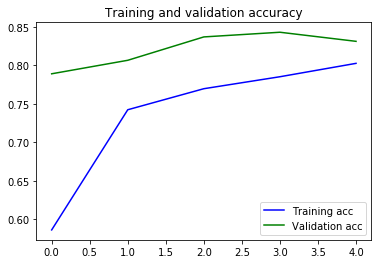

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc', color = "blue")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = "green")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.show()

In [12]:
# Test set score:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(240,240),
        batch_size= 60,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 2962 images belonging to 11 classes.
test acc: 0.8257933855056763
